## Notebook 01a: Understanding the sub-SEVIR Regression ML Models 

### Goal: Interogate the pre-trained regression ML models 

#### Background 

In the [previous notebook](https://github.com/ai2es/tai4es-trustathon-2022/blob/main/severe/notebooks/Notebook_00a_Train_Regression_Models.ipynb), we trained and evaluated classification models on the sub-SEVIR dataset. Of the three models trainined and evaluated, the best performing model was the **gradient-boosted trees (GBT)** model. Our goal is now to understand how the model works. 


 </div> <div class="alert alert-block alert-warning"><b>Optional: </b> Repeat the following tasks, but for the random forest and linear regression. Their performance was slightly less than GBT, so what did they fail to learn? To run those models, replace the estimator_name below with 'RF or 'LR'.</div>


#### Tasks

1. Determine the important features.
2. Assess the learned relationships. 
3. Explain individual predictions.
 

In [1]:
# Add ../scripts to our path so we can import functions from there.
import sys,os
sys.path.append('../scripts')        
from util import load_ml_data
from verification import plot_verification
from plotting_config import display_feature_names, color_dict

### Import the neccesary thrid-party packages

In [2]:
#needed packages 
import numpy as np
import pandas as pd
import joblib
import skexplain
import shap

### Load the data. 

The data has been pre-split into training, validation, and testing datasets. 

In [3]:
# Load the data.
X_train, y_train, X_val, y_val, X_test, y_test = load_ml_data(task='regression')

### Load the ML models. 

For this tutorial, we will load the two tree-based models (Gradient-Boosted Tree) and a logistic regression model that was trained on the SEVIR dataset. 


In [4]:
# Load the pre-trained ML models into the skexplain format (estimator name, estimator)
estimator_names = ['GBT']
estimators = [(estimator_name, joblib.load(f'../models/{estimator_name}_regression.joblib')) 
              for estimator_name in estimator_names]

## Task 1. Analyze the Important Features 

An initial task for understanding an ML model is understanding the important features – those features that contribute most to the model's performance. If the model performs well on independent data, then these features might provide insight into the data-generating process. The common approach for assessing feature importance is the permutation importance method. There are different flavors of permutation importance, which were covered in the lecture series. For this tutorial, we will evaluate the backward and forward versions of the single-pass and multipass permutation importance. 


When explaining global characteristics of a model like model performance and/or learned relationships, we want to use the training dataset. The goal of measuring feature importance or learned relationships is to quantify how the model relies on each feature and not how well the model generalizes to unseen data. If the ML model learned a pattern in the training dataset that it is underrepresented in the independent dataset it can bias the feature ranking. For example, imagine we had an ML model trained to predict subfreezing road surface temperatures. If the ML model
learned that the road surfaces freeze only at temperatures $<$ -10 $^{\circ}$C, but the independent dataset is mainly composed of temperature samples between -5--0$^{\circ}$C, then temperature would have reduced importance. Therefore, the feature importances and the learned relationships in this tutorial are evaluated using the training dataset.

In [7]:
explainer = skexplain.ExplainToolkit()

### Task 1a. (optional) Run the skexplain code yourself. 

For more information on the permutation importance in scikit-explain, check out this [tutorial] (https://github.com/monte-flora/scikit-explain/blob/master/tutorial_notebooks/permutation_importance_tutorial.ipynb). Play around with `subsample` size or the `evaluation_fn` used. Is there any sensitivity? 

In [6]:
# Load the permutation importance results. 
results_backward = explainer.load(f'../datasets/perm_imp_backward_mse.nc')
results_forward = explainer.load(f'../datasets/perm_imp_forward_mse.nc')

### Plot the Important Features. 

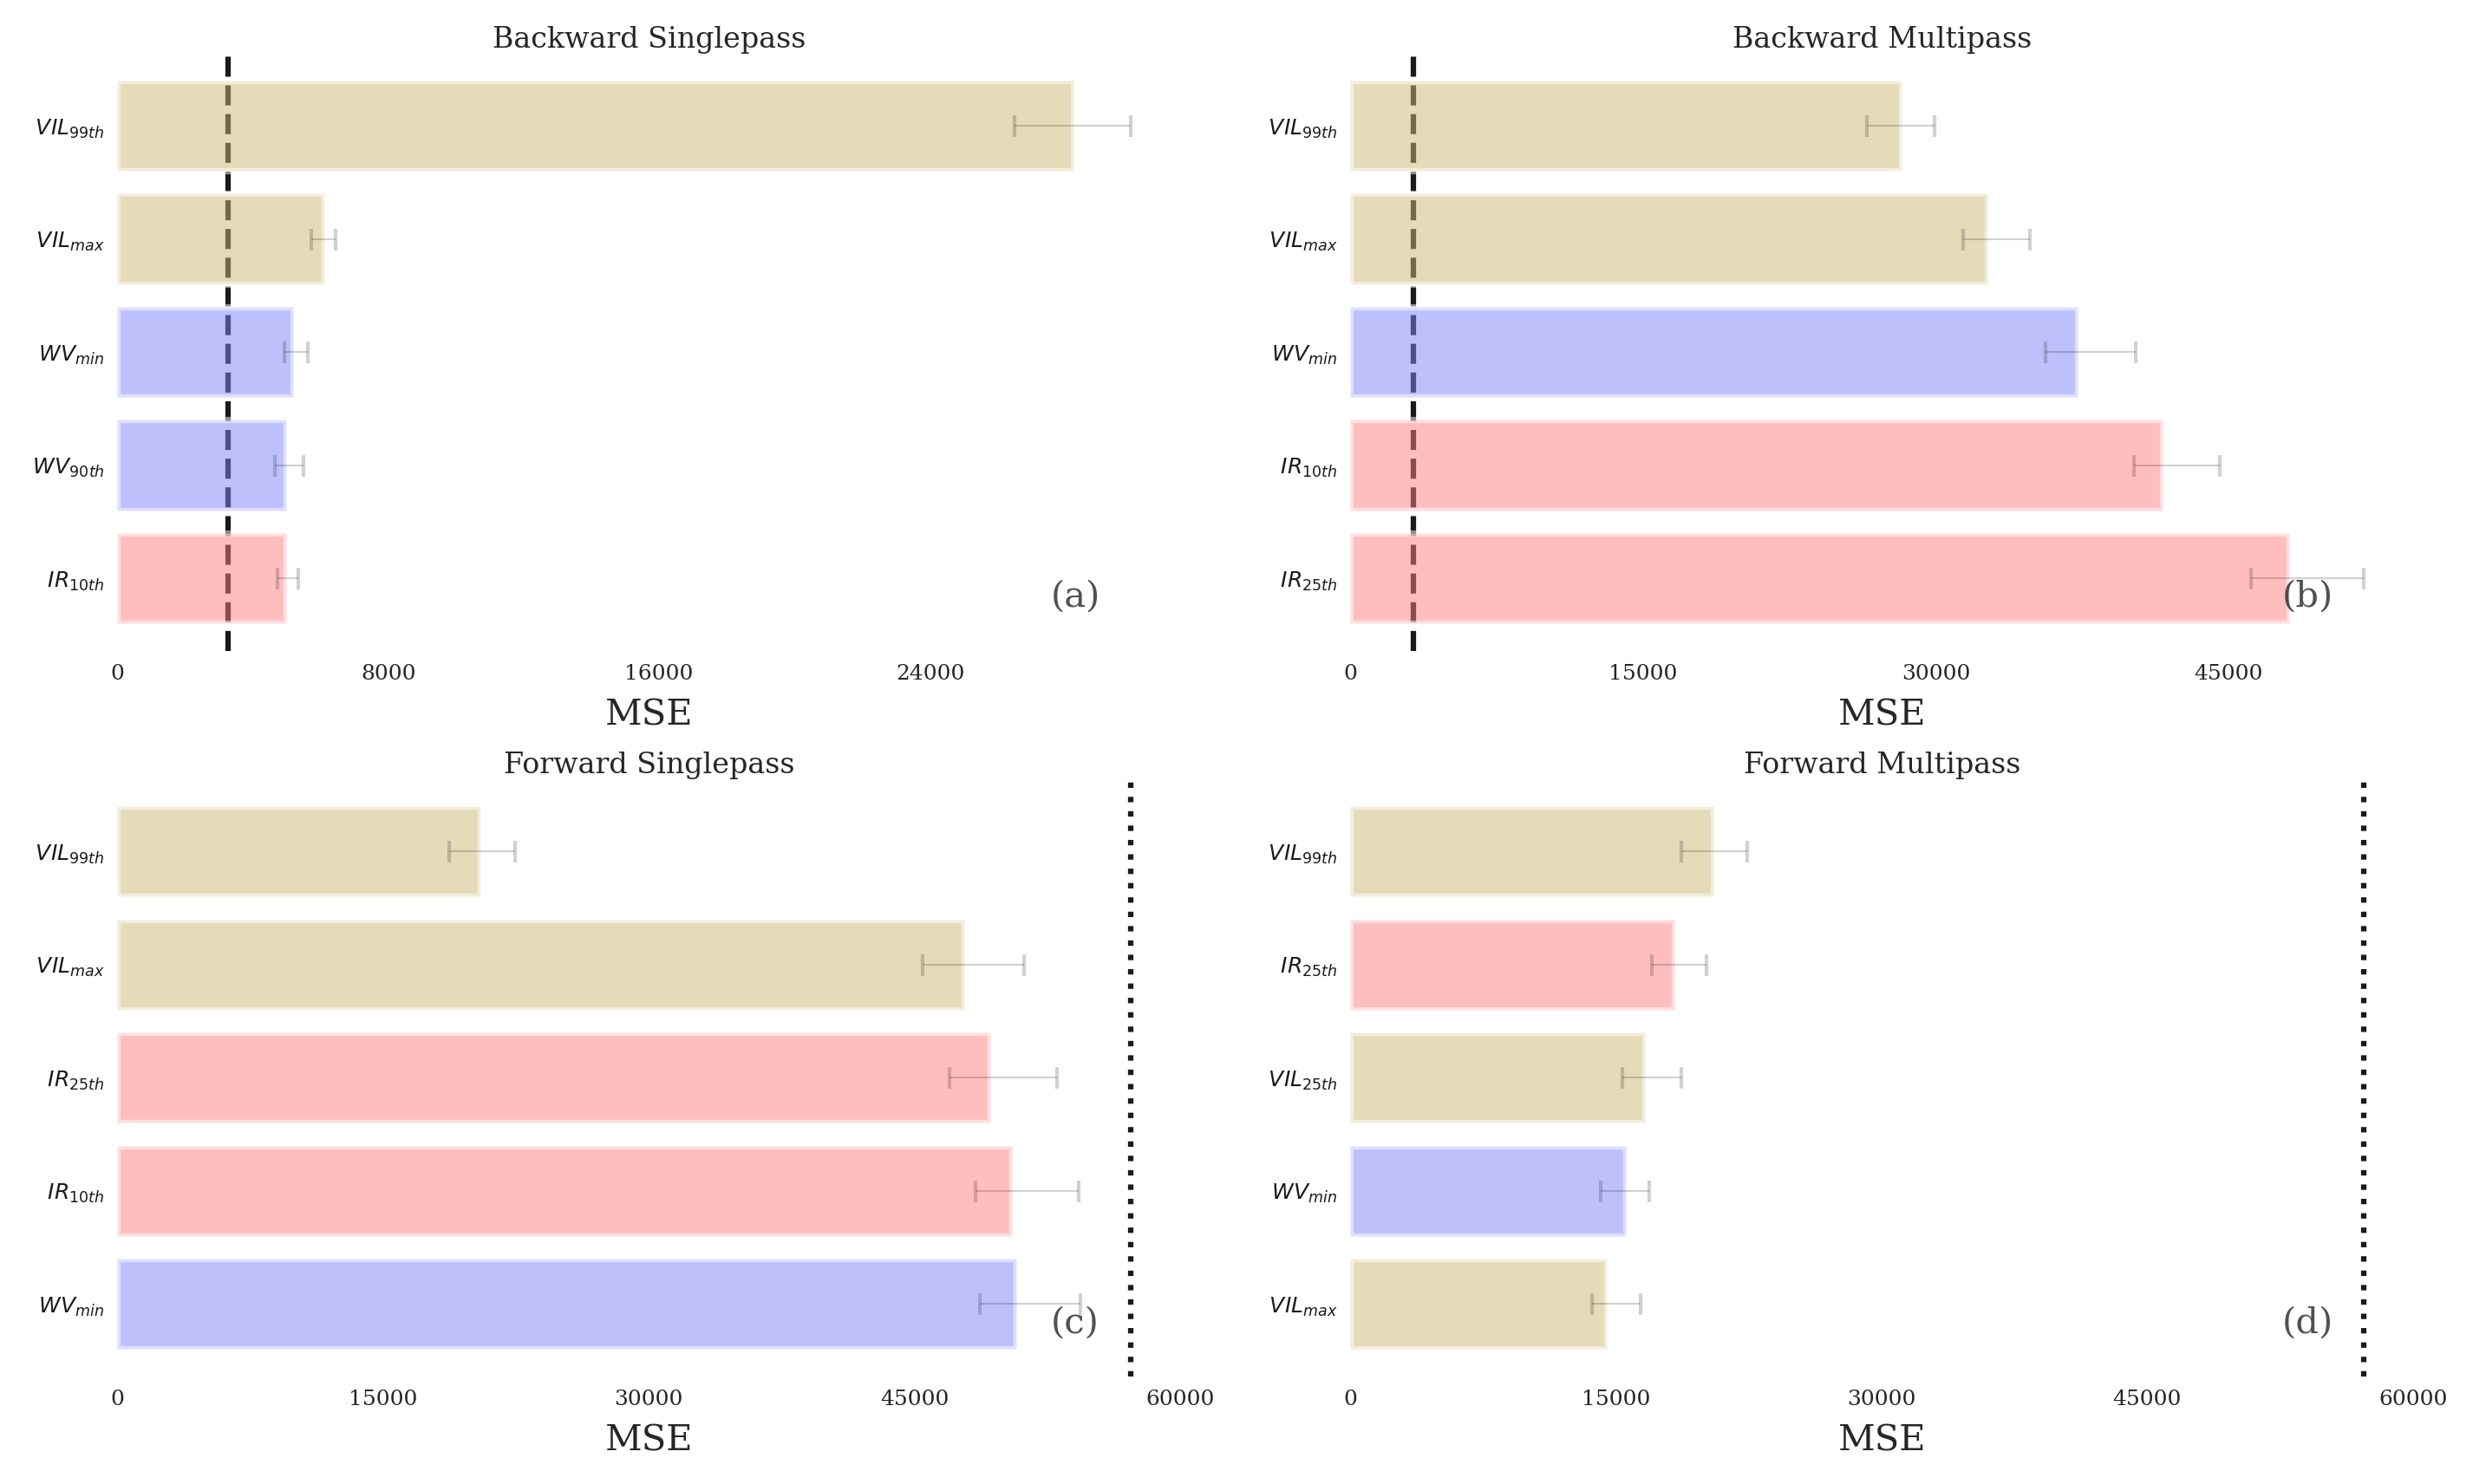

In [12]:
import itertools
explainer = skexplain.ExplainToolkit(estimators, X_train, y_train)

types = ['backward_singlepass', 'backward_multipass', 'forward_singlepass', 'forward_multipass'
]
titles = [t.replace('_', ' ').title() for t in types]
panels = [(t, n) for n,t in itertools.product(estimator_names, types)]

fig,axes = explainer.plot_importance(data=[results_backward, results_backward, 
                                           results_forward, results_forward]*len(estimator_names), 
                                panels=panels,
                                num_vars_to_plot=5,
                                xlabels=['MSE']*len(panels),
                                display_feature_names=display_feature_names, 
                                feature_colors=color_dict, 
                                n_columns=2, 
                                figsize=(10,6),
                                 )

for ax, title in zip(axes.flat, titles):
    ax.set_title(title, pad=0.02)

The color coding is as follows: 
1. Red : Infrared (IR) brightness temperature-based features
2. Purple: Water vapor (WV) brightness temperature-based features
3. Gold: Vertically integrated liquid (VIL)-based features

For 3 out of the 4 permutation importance methods,  spatial-99th percentile VIL (VIL$_{99th}$) and maximum VIL (VIL$_{max}$) were the top 2 features. Conversely, for the classification models, all four permutatiom importance methods agreed on the top 2 features. In this case, the forward multipass found that VIL$_{99th}$ and spatial-25th percentile IR temperature (IR$_{25th}$) were the top 2 features. Recall that for the forward permutation importance methods, all features start jointly permuted and are un-permuted to assess how model performance improves. Thus, the forward multipass suggest thats if only VIL$_{99th}$ and IR$_{25th}$ were unpermuted, they produce the best model performance as opposed to any other combo with VIL$_{99th}$. 

Unfortunately, when features are correlated with each other it complicates the interpretation of the results. Since the dataset is composed of multiple spatial percentile of the same variable, there will be strong linear correlations between features. For example,  VIL$_{99th}$ and VIL$_{max}$ are correlated with each other (which isn't surprising). This calls into questions whether VIL$_{99th}$ and/or VIL$_{max}$ have biased ranks due to the correlation between them. 

In the next cell, we plot the correlation coefficient matrix to evaluate the relationship between features. 

this method is deprecated in favour of `Styler.format(precision=..)`


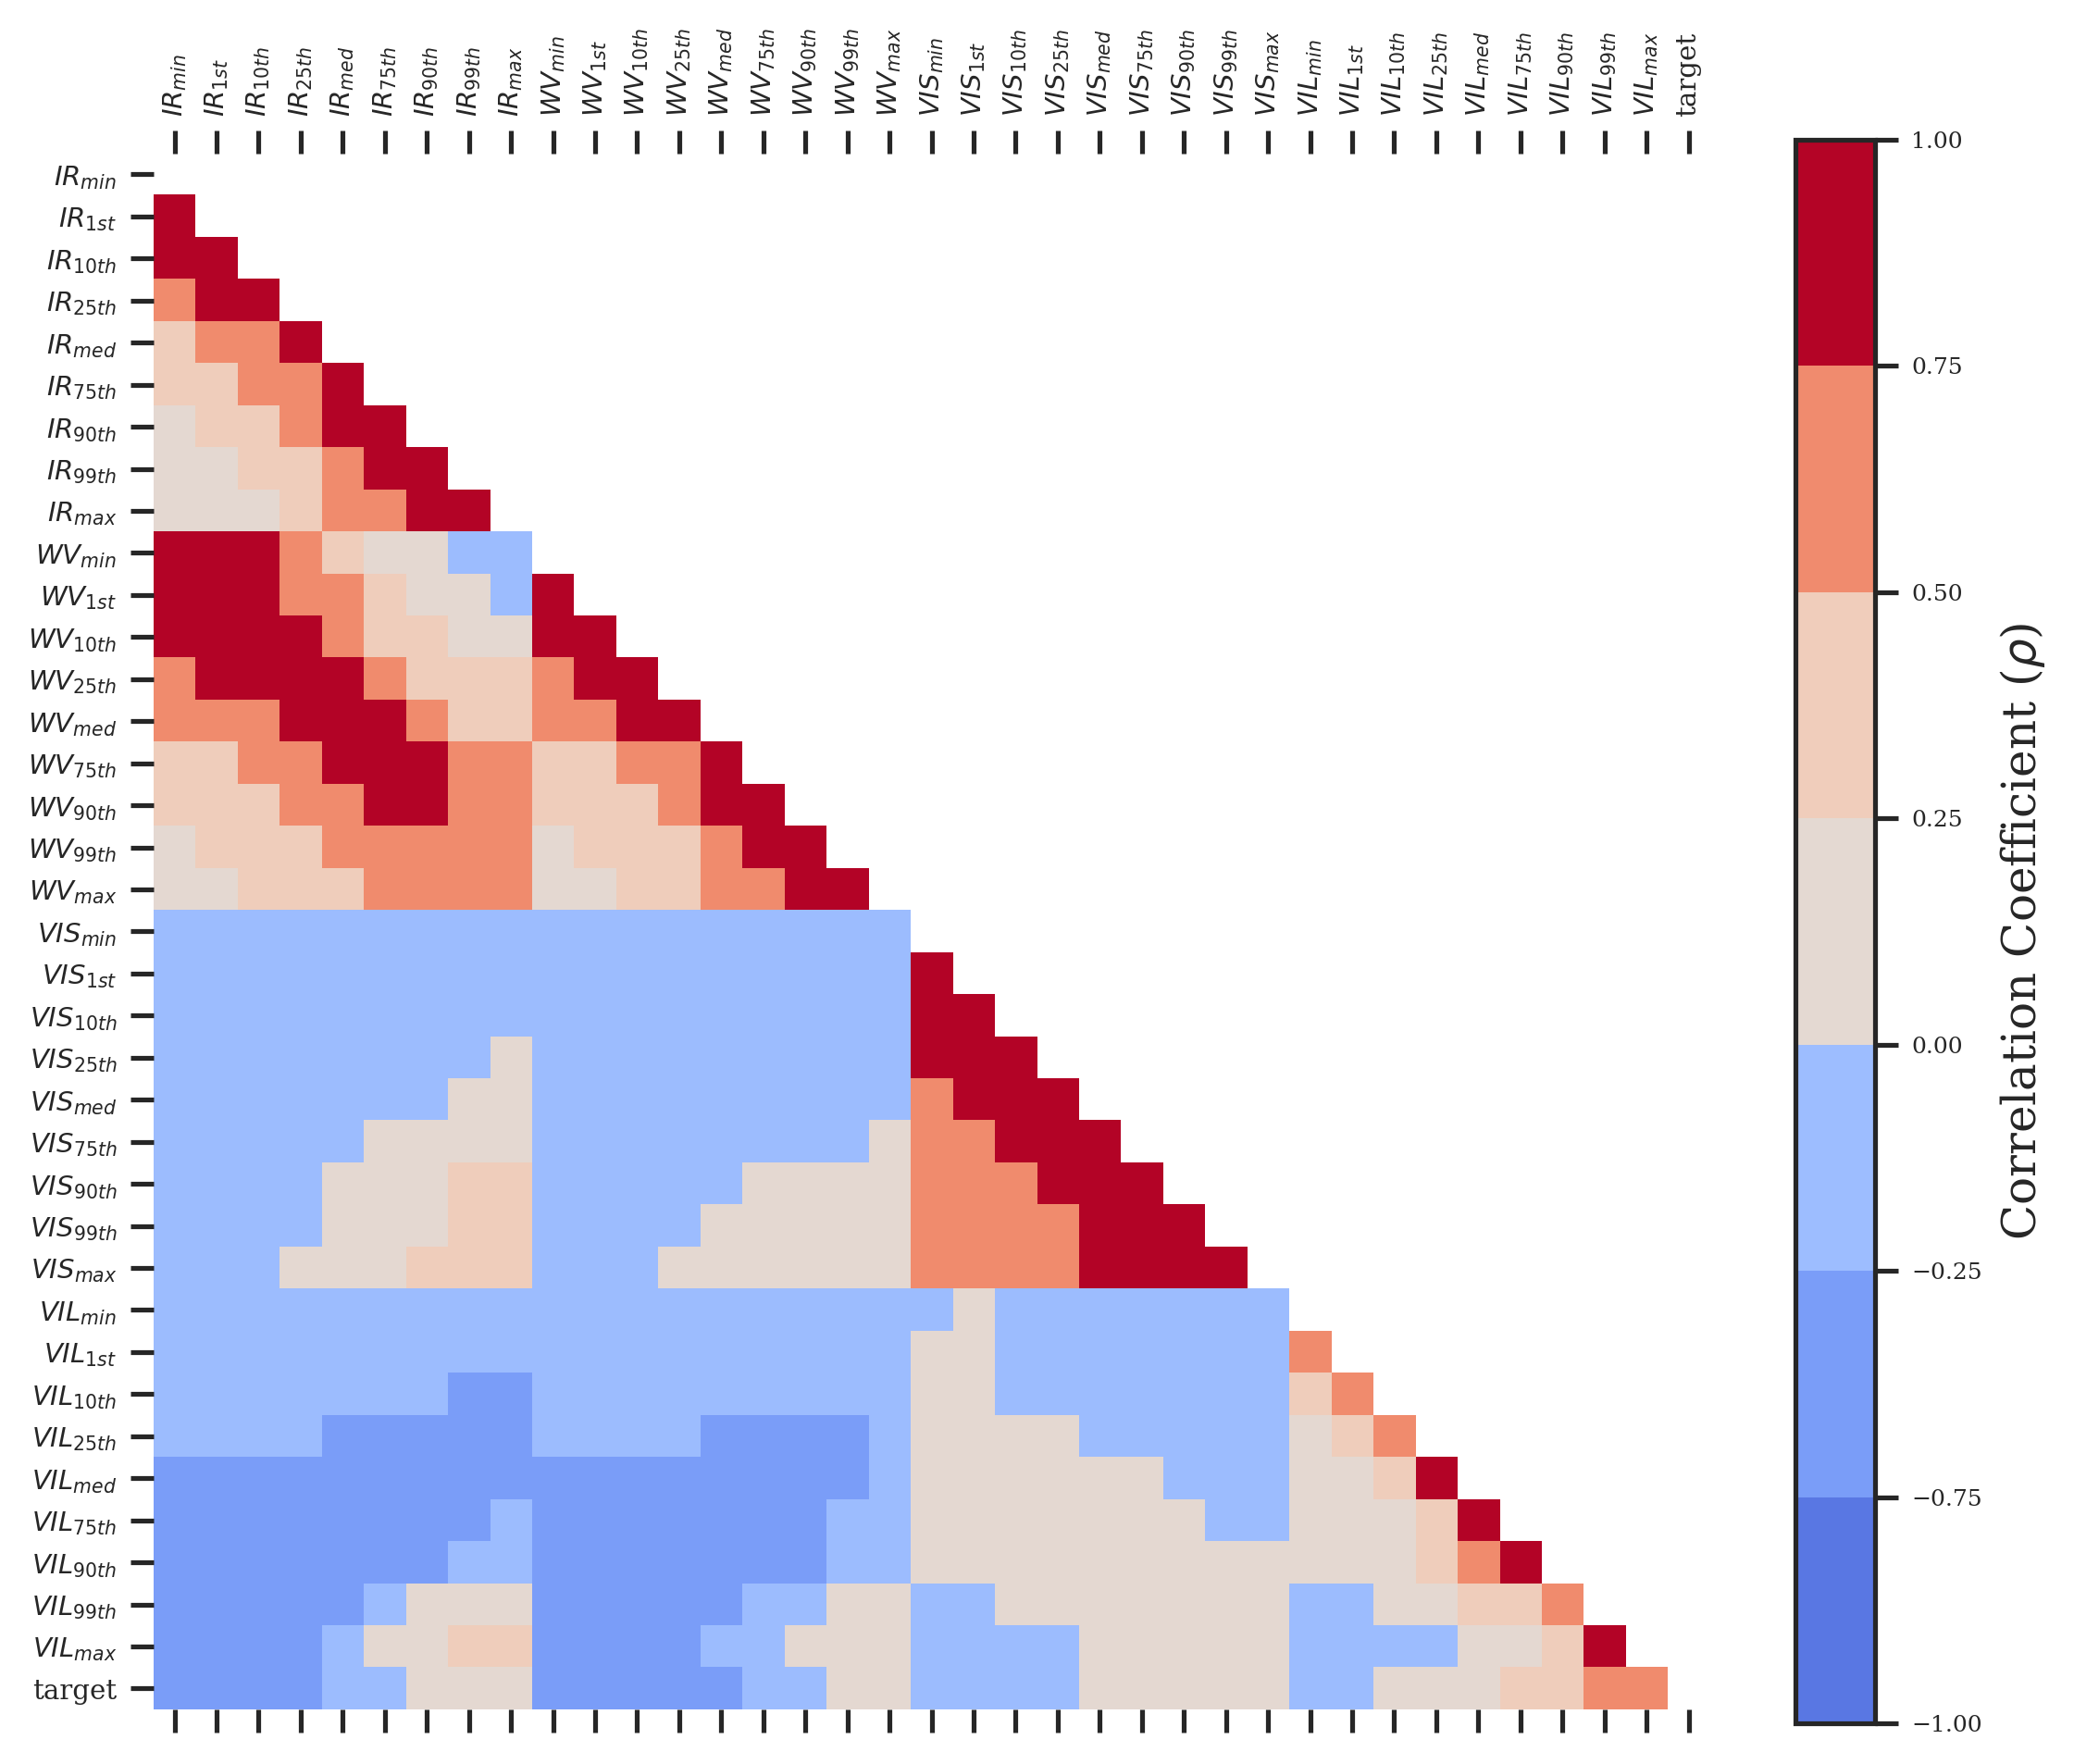

In [21]:
# Change this cell back to 'Code' to see the correlation coefficient matrix. 

import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors

X_renamed = X_train.rename(mapper=display_feature_names, axis=1)
X_renamed['Target'] = y_train
corr = X_renamed.corr()

mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

fig, ax = plt.subplots(figsize=(8, 8), dpi=300)

nice_cmap = plt.get_cmap('coolwarm')
# Pick some of the nicer colors from the palette...
colors = nice_cmap([ 25, 50, 75, 135, 150, 200, 300, ])
levels = [-1.0, -0.75, -0.25, 0, 0.25, 0.5, 0.75, 1.0]

cmap, norm = from_levels_and_colors(levels, colors,)

c = ax.matshow(corr, cmap=cmap,norm=norm)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=7)
plt.yticks(range(len(corr.columns)), corr.columns, fontsize=7)
plt.colorbar(c, label=r'Correlation Coefficient ($\rho$)', fraction=0.046)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

As stated above, for a particular variable, its different spatial percentiles are decently correlated with each other. There is not much correlation between variables expect IR and WV temperatures. 

## Task 2. Analyze the Learned Relationships

To evaluate the learned relationships we use the accumuluted local effects rather than partial dependence.
For more details on the accumulated local effects, see this [tutorial notebook](https://github.com/monte-flora/scikit-explain/blob/master/tutorial_notebooks/accumulated_local_effect_tutorial.ipynb).


In [8]:
# Get the important features from both the backward and forward perm. imp. results.
important_vars = []
for results in [results_backward, results_forward]:
    v = explainer.get_important_vars(results_backward, n_vars=2)[estimator_names[0]]
    important_vars.extend(v)

# Keep the unique features 
important_vars = list(set(important_vars))
    
# Compute the ALE 
ale_1d_ds = explainer.ale(features=important_vars, subsample=0.25, n_jobs=2, n_bins=20, )

  0%|          | 0/5 [00:00<?, ?it/s]

(<Figure size 1800x1200 with 12 Axes>,
 array([[<AxesSubplot:xlabel='$IR_{10th}$'>,
         <AxesSubplot:xlabel='$IR_{25th}$'>,
         <AxesSubplot:xlabel='$VIL_{max}$'>],
        [<AxesSubplot:xlabel='$WV_{min}$'>,
         <AxesSubplot:xlabel='$VIL_{99th}$'>, <AxesSubplot:>]],
       dtype=object))

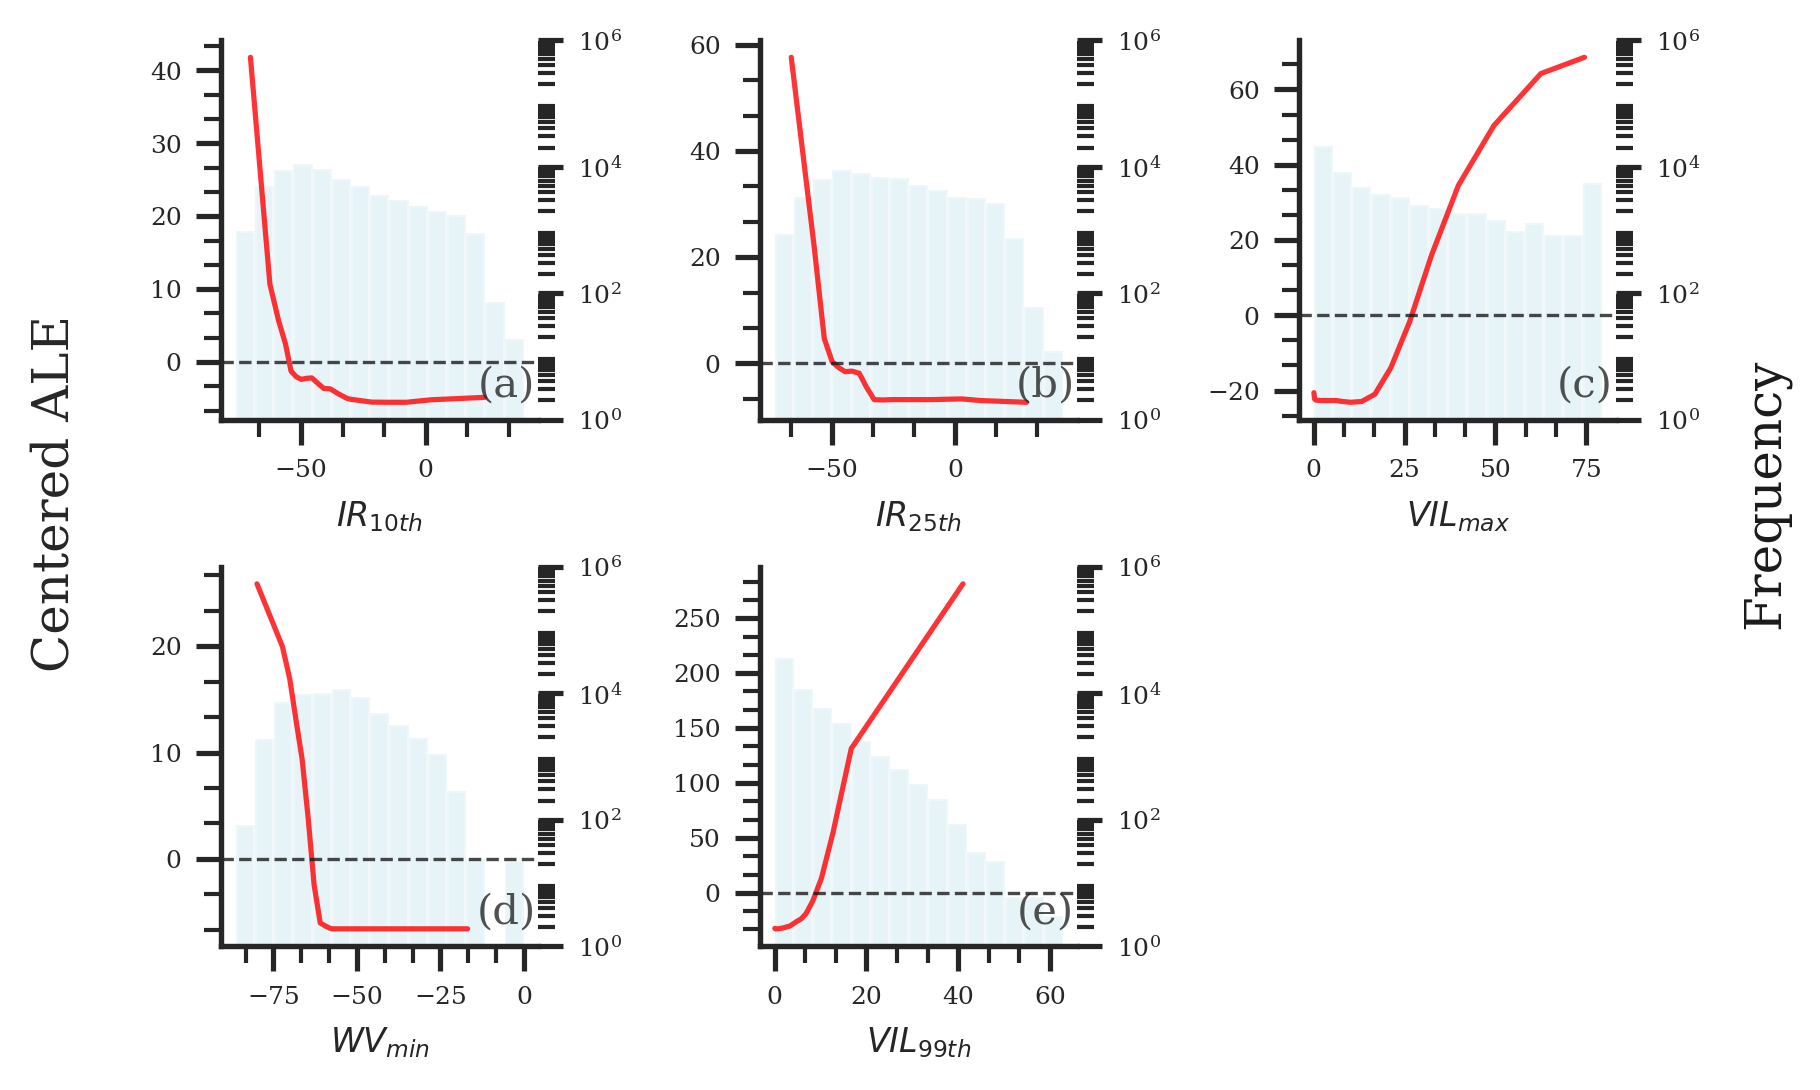

In [9]:
explainer.plot_ale(ale_1d_ds, display_feature_names=display_feature_names, figsize=(6,4))

The importance of VIL$_{99th}$ (panel e) to the GBT model is understandable as we can see that slight increases in VIL$_{99th}$ lead to substantial changes in the number of flashes. For example, VIL$_{99th}$ $\approx$ 15 has zero impact on the model prediction, but VIL$_{99th}$ $\approx$ 20 increases the flash amount by 150 on average. The sensitivity to the other top features is more modest. For example, unless the spatial-10th percentile IR (panel a) temperature is below -50 C, the model prediction is insensitive to this feature (constant negative contribution).

We can see that the possible contributions from VIL$_{max}$ (panel c) and IR$_{25th}$ (panel b) are similar. 

IR$_{25th}$ is correlated with WV whereas VIL is fairly uncorrelated with the other features. 

so it seems reasonable why the forward multipass ranked IR$_{25th}$ higher. 



## Task 4. Explain individual predictions

In Task 1 and 2, we explored global charactersistic of the model. We know that VIL$_{max}$ and IR$_{min}$ are the two main contributors to model performance and the learned relationships for both features is physically consistent. The model is not perfect and will make incorrect predictions. Can we use local explainability methods to understand what the typical false alarms or miss looks like? Can we anticipate failure modes? In the following example, we will use Shapley values to breakdown how each feature contributes to a single model prediction. Instead of looking at random examples, we will examine average contributions to the top 5 best hits (high confidence of lightning and lightning observed), worst false alarms (high confidence, but no lightning flash), worst misses (low confidence, but lightning flash was observed), and correct negatives (low confidence and no lightning flash occurred).


Unlike the global explainability, we are free to use the training or testing dataset for local explainability. For this task, we switch to testing dataset for the following examples.

In [39]:
results = explainer.local_contributions(method='shap', 
                                       performance_based=True,
                                       n_samples=5, 
                                       shap_kwargs={'masker' : 
                                      shap.maskers.Partition(X_train, max_samples=100, clustering="correlation"), 
                                     'algorithm' : 'auto'}
                                          )

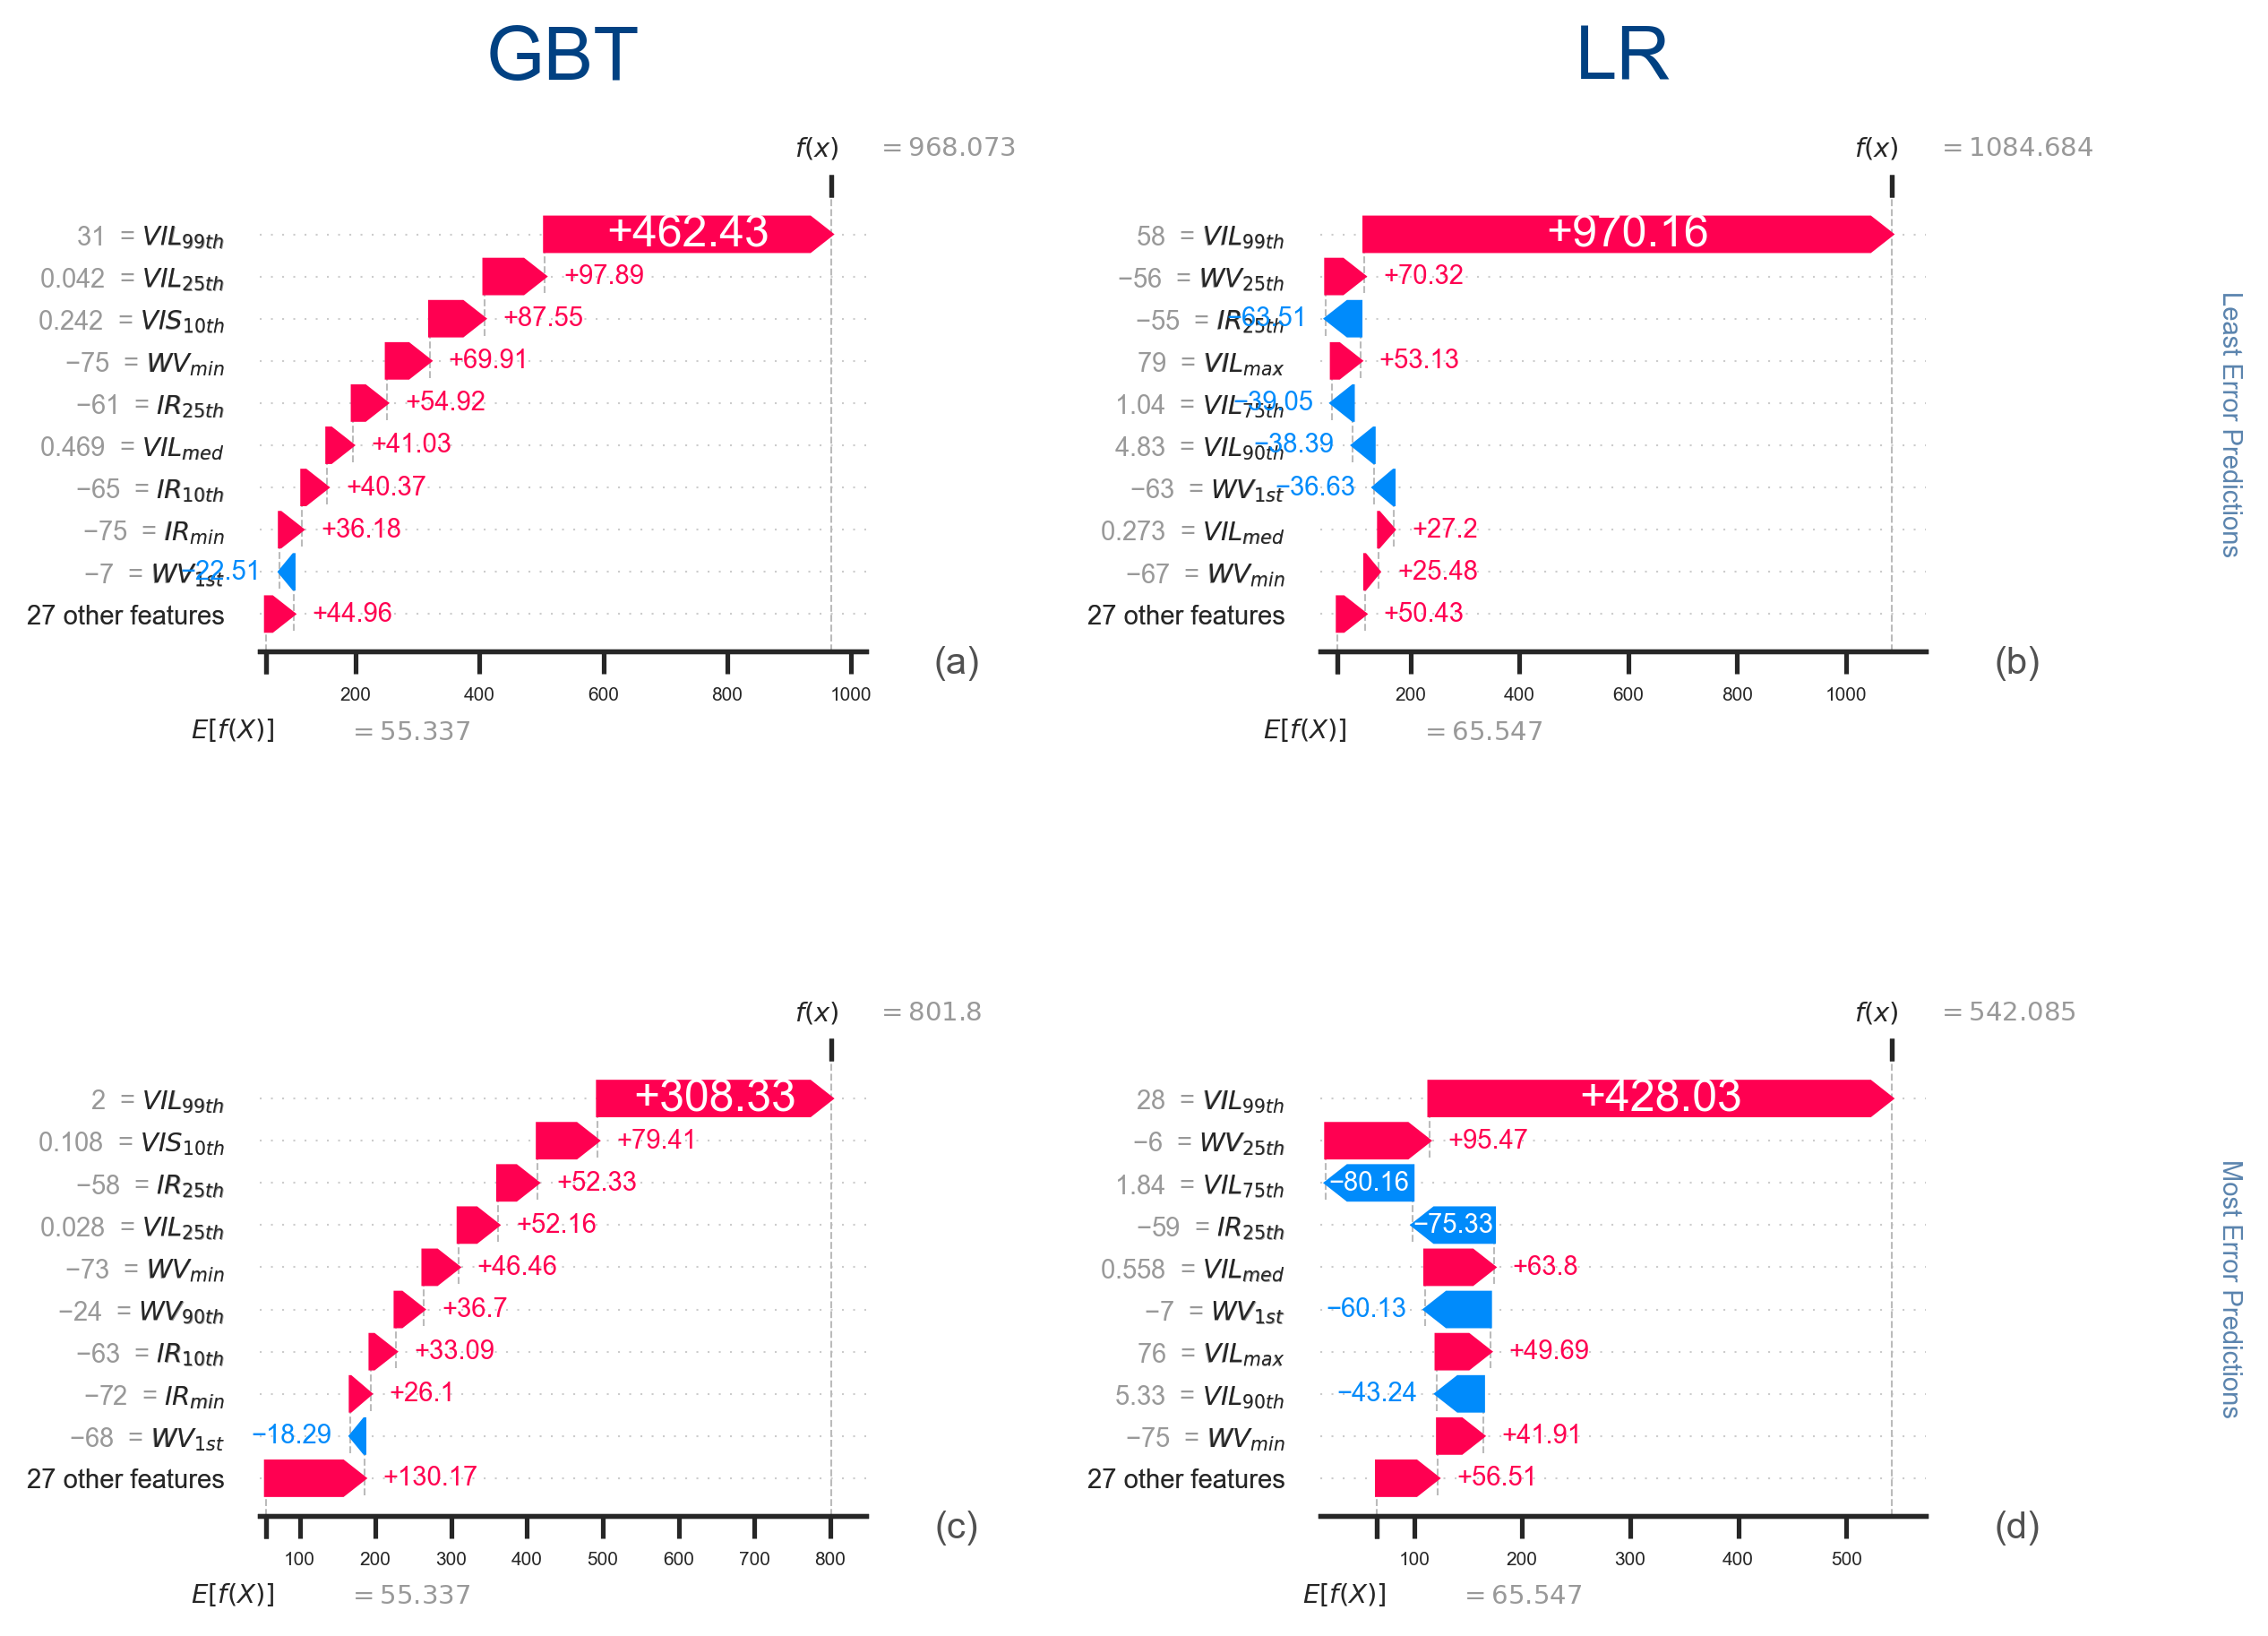

In [41]:
fig = explainer.plot_contributions(contrib=results,  
                            display_feature_names=display_feature_names,
                                   n_columns=2
                        )

The VIL$_{max}$ and IR$_{min}$ values (78 & 79 and -74 &-69, respectively) are comparable for the best hits and worst false alarms and they are the top contributors, which is consistent with the global results. Though we can include the files in this tutorial, we explored the dataset to determine the source of the false alarm. In the below animation, we can see that for two timesteps, there was a data outage as the GLM lightning flash data was missing. Thus, the false alarm in this case was likely a hit. 



In [ ]:
from IPython.display import Video
Video("FalseAlarm.mp4")

In this next animation, we can see the cause of the worst misses. In this case, the IR temperatures were low in the region of observed lightning flashes, but the VIL data was missing, giving erroroeously low values. 

In [ ]:
from IPython.display import Video
Video("another_miss.mp4")

In both the worst false alarm and worst misses, the cause was linked to missing or bad data and not neccesarily the ML model. Given the high accuracy of the model, it is probably fair to assume that the cause of other bad false alarms and misses are linked to dad or missing data.